In [1]:
import agama
import gizmo_analysis as gizmo  # rename these packages for brevity
import numpy as np
import utilities as ut  # rename these packages for brevity

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# simulation_directory = "/Volumes/My Passport for Mac/m12i_res7100"
simulation_directory = "/Users/z5114326/Documents/SampleData/m12i_res7100"
part = gizmo.io.Read.read_snapshots("all", "redshift", 0, simulation_directory, assign_hosts_rotation=True)


# in utilities.simulation.Snapshot():
* reading:  Users/z5114326/Documents/SampleData/m12i_res7100/snapshot_times.txt

* input redshift = 0:  using snapshot index = 600, redshift = 0.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  Users/z5114326/Documents/SampleData/m12i_res7100/output/snapdir_600/snapshot_600.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 70514272 particles
    dark2     (id = 2): 5513331 particles
    gas       (id = 0): 57060074 particles
    star      (id = 4): 13976485 particles
    blackhole (id = 5): 0 particles

* reading the following
  species: ['dark', 'dark2', 'gas', 'star']

* reading particles from:
    snapshot_600.0.hdf5
    snapshot_600.1.hdf5
    snapshot_600.2.hdf5
    snapshot_600.3.hdf5

* reading cosmological parameters from:  Users/z5114326/Documents/SampleData/m12i_res7100/initial_condition/ic_agora_m12i.conf

* checking sanity of particle properties


# in gizmo_analysis.gizmo_track.Par

In [3]:
pos_limit = 1000  # kpc

bary_pos_hold = []
bary_mass_hold = []

bary_ptypes = ["star", "gas"]

for ptype in bary_ptypes:
    position_lst = part[ptype].prop("host1.distance.total")
    mask = position_lst < pos_limit
    bary_pos_hold.append(np.array(part[ptype].prop("host1.distance.principal", mask)))
    bary_mass_hold.append(np.array(part[ptype]["mass"][mask]))

bary_pos_args = (bary_pos_hold[0], bary_pos_hold[1])
bary_pos = np.concatenate(bary_pos_args)

bary_mass_args = (bary_mass_hold[0], bary_mass_hold[1])
bary_mass = np.concatenate(bary_mass_args)

In [4]:
dark_pos_hold = []
dark_mass_hold = []

dark_ptypes = ["dark", "dark2"]

for ptype in dark_ptypes:
    position_lst = part[ptype].prop("host1.distance.total")
    mask = position_lst < pos_limit
    dark_pos_hold.append(np.array(part[ptype].prop("host1.distance.principal", mask)))
    dark_mass_hold.append(np.array(part[ptype]["mass"][mask]))

dark_pos_args = (dark_pos_hold[0], dark_pos_hold[1])
dark_pos = np.concatenate(dark_pos_args)

dark_mass_args = (dark_mass_hold[0], dark_mass_hold[1])
dark_mass = np.concatenate(dark_mass_args)

In [5]:
pos_hold = []
cyl_hold = []
mass_hold = []

for ptype in part.keys():
    position_lst = part[ptype].prop("host1.distance.total")
    mask = position_lst < pos_limit
    pos_hold.append(np.array(part[ptype].prop("host1.distance.principal", mask)))
    cyl_hold.append(np.array(part[ptype].prop("host.distance.principal.cylindrical", mask)))
    mass_hold.append(np.array(part[ptype]["mass"][mask]))

pos_args = (pos_hold[0], pos_hold[1], pos_hold[2], pos_hold[3])
pos_base = np.concatenate(pos_args)

cyl_args = (cyl_hold[0], cyl_hold[1], cyl_hold[2], cyl_hold[3])
cyl_base = np.concatenate(cyl_args)

mass_args = (mass_hold[0], mass_hold[1], mass_hold[2], mass_hold[3])
mass_base = np.concatenate(mass_args)

In [59]:
agama.setUnits(length=1, velocity=1, mass=1)

pot_nbody_dark = agama.Potential(
    type="Multipole",
    particles=(dark_pos, dark_mass),  # dark matter particles from snapshot
    symmetry="axisymmetric",
    lmax=2,
    mmax=0,
    gridSizeR=20,
)

pot_nbody_bary = agama.Potential(
    type="CylSpline",
    particles=(bary_pos, bary_mass),  # gas and star (baryonic) particles from snapshot
    symmetry="axisymmetric",
    mmax=0,
    gridSizeR=20,
    gridSizeZ=20,
)

pot_nbody = agama.Potential(pot_nbody_dark, pot_nbody_bary)  # combine components into single potential

print(pot_nbody)

CompositePotential{ Multipole, CylSpline } (symmetry: Axisymmetric)


In [60]:
gridR = agama.nonuniformGrid(500, 0.01, 1000)
gridz = agama.symmetricGrid(100, 0.01, 100)
grid2R, grid2z = np.meshgrid(gridR, gridz)
gridRz = np.column_stack((grid2R.reshape(-1), grid2z.reshape(-1)))
gridx0z = np.column_stack((grid2R.reshape(-1), grid2R.reshape(-1) * 0, grid2z.reshape(-1)))
gridR00 = np.column_stack((gridR, gridR * 0, gridR * 0))
grid00z = np.column_stack((gridz * 0, gridz * 0, gridz))

In [54]:
def radial_dens(rad_set, z_set, r_bin_size, z_bin_size, cyl_base, mass_base):
    r_min, r_max = rad_set - r_bin_size / 2, rad_set + r_bin_size / 2
    z_min, z_max = z_set - z_bin_size / 2, z_set + z_bin_size / 2

    r_lst = cyl_base[:, 0]
    z_lst = cyl_base[:, 2]

    mask = np.where((r_lst >= r_min) & (r_lst <= r_max) & (z_lst >= z_min) & (z_lst <= z_max))
    mass_test = mass_base[mask]

    mas = np.sum(mass_test)
    vol = z_bin_size * np.pi * (r_max**2 - r_min**2)
    density = mas / vol

    return density

In [75]:
def z_dens(z_set, z_bin_size, r_min, r_max, cyl_base, mass_base):
    z_min, z_max = z_set - z_bin_size / 2, z_set + z_bin_size / 2

    r_lst = cyl_base[:, 0]
    z_lst = cyl_base[:, 2]

    mask = np.where((r_lst >= r_min) & (r_lst <= r_max) & (abs(z_lst) >= z_min) & (abs(z_lst) <= z_max))
    mass_test = mass_base[mask]

    mas = np.sum(mass_test)
    vol = 2 * z_bin_size * np.pi * (r_max**2 - r_min**2)
    density = mas / vol

    return density

In [171]:
rad_lst = np.logspace(-2, 3, 25)
rad_bin = np.logspace(-3, 0, 25)

r_density_lst = []

for radius, r_bin_size in zip(rad_lst, rad_bin):
    density = radial_dens(radius, 0, r_bin_size, 0.1, cyl_base, mass_base)
    r_density_lst.append(density)

In [227]:
z_lst = np.logspace(-3, 2, 25)
z_bin = np.logspace(-3, 1, 25)
r_max_lst = np.logspace(-2, 1, 25)

# z_lst = np.linspace(1e-2, 1e2, 25)
# z_bin = np.linspace(1e-3, 1, 25)

z_density_lst = []

for z_set, z_bin_size, r_max in zip(z_lst, z_bin, r_max_lst):
    density = z_dens(z_set, z_bin_size, 0, r_max, cyl_base, mass_base)
    z_density_lst.append(density)

(100000.0, 50000000000.0)

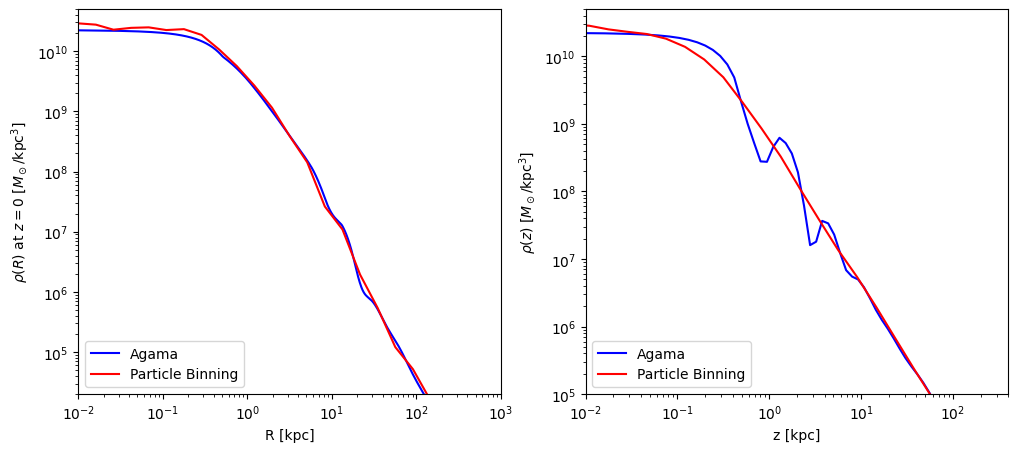

In [228]:
ax = plt.subplots(1, 2, figsize=(12, 5))[1]
ax[0].loglog(gridR, pot_nbody.density(gridR00), label="Agama", color="blue")
ax[0].loglog(rad_lst, r_density_lst, label="Particle Binning", color="red")

ax[0].set_xlabel("R [kpc]")
ax[0].set_ylabel(r"$\rho(R)$ at $z=0$ $[M_\odot/\mathsf{kpc}^3]$")
ax[0].legend(loc="lower left")
ax[0].set_xlim(1e-2, 1e3)
ax[0].set_ylim(2e4, 5e10)

ax[1].loglog(gridz, pot_nbody.density(grid00z), label="Agama", color="blue")
ax[1].loglog(z_lst, z_density_lst, label="Particle Binning", color="red")

ax[1].set_xlabel("z [kpc]")
ax[1].set_ylabel(r"$\rho(z)$ $[M_\odot/\mathsf{kpc}^3]$")
ax[1].legend(loc="lower left")
ax[1].set_xlim(1e-2, 4e2)
ax[1].set_ylim(1e5, 5e10)